# Kaggle-Plant Seedlings Classification

## Description

This project aims to classify images of plant seedlings into 12 different species using deep learning. The dataset, provided by the Aarhus University Signal Processing group in collaboration with the University of Southern Denmark, contains approximately 960 unique plants at various growth stages.

We implement a Convolutional Neural Network (CNN) with transfer learning using MobileNetV2 to learn from the provided RGB images. The goal is to accurately identify the species of a seedling from its image, which has implications for improved crop yield and weed management.

Key components of this project include:
- Data preprocessing and augmentation
- CNN architecture and training
- Evaluation metrics (accuracy, confusion matrix)
- Visualization of prediction results

## Dataset Description

The dataset used in this project is from the Kaggle competition “Plant Seedlings Classification”. It contains images of plant seedlings taken at various stages of growth, captured under natural lighting conditions.

The training dataset includes 5,545 PNG images, distributed across 12 plant species. Each image is stored in a folder named after its plant species, making it suitable for image classification tasks using tools like `ImageFolder` (in PyTorch) or `flow_from_directory` (in Keras).

### Species classes:
- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherd’s Purse
- Small-flowered Cranesbill
- Sugar beet


In [ ]:
!pip install opencv-python

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Image processing
from PIL import Image
import cv2

# Deep learning (Keras / TensorFlow)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# Visualization
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


## Data Visualization & EDA

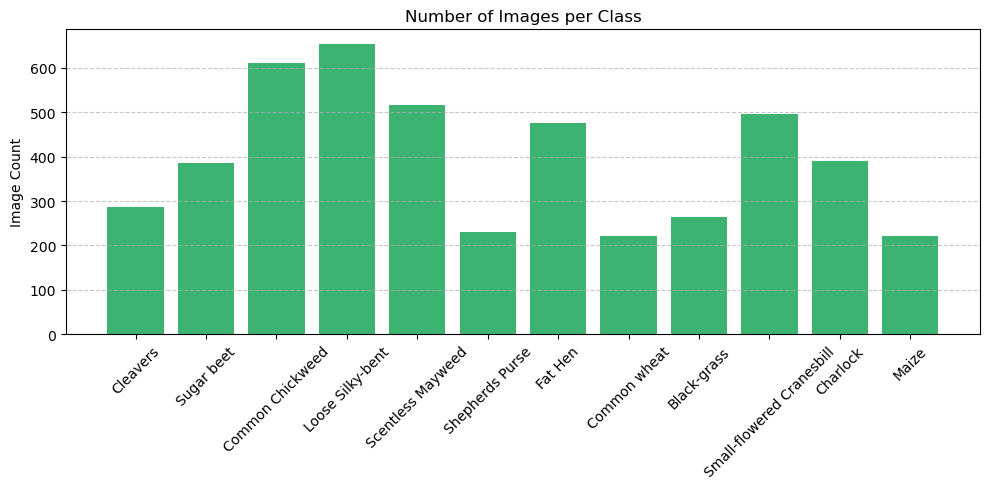

In [3]:
# Class Distribution Visualization (Bar Chart)
# Set training data path
train_dir = 'train/'

# Count the number of images in each class subfolder
class_counts = {
    cls: len(os.listdir(os.path.join(train_dir, cls)))
    for cls in os.listdir(train_dir)
}

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='mediumseagreen')
plt.xticks(rotation=45)
plt.title("Number of Images per Class")
plt.ylabel("Image Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

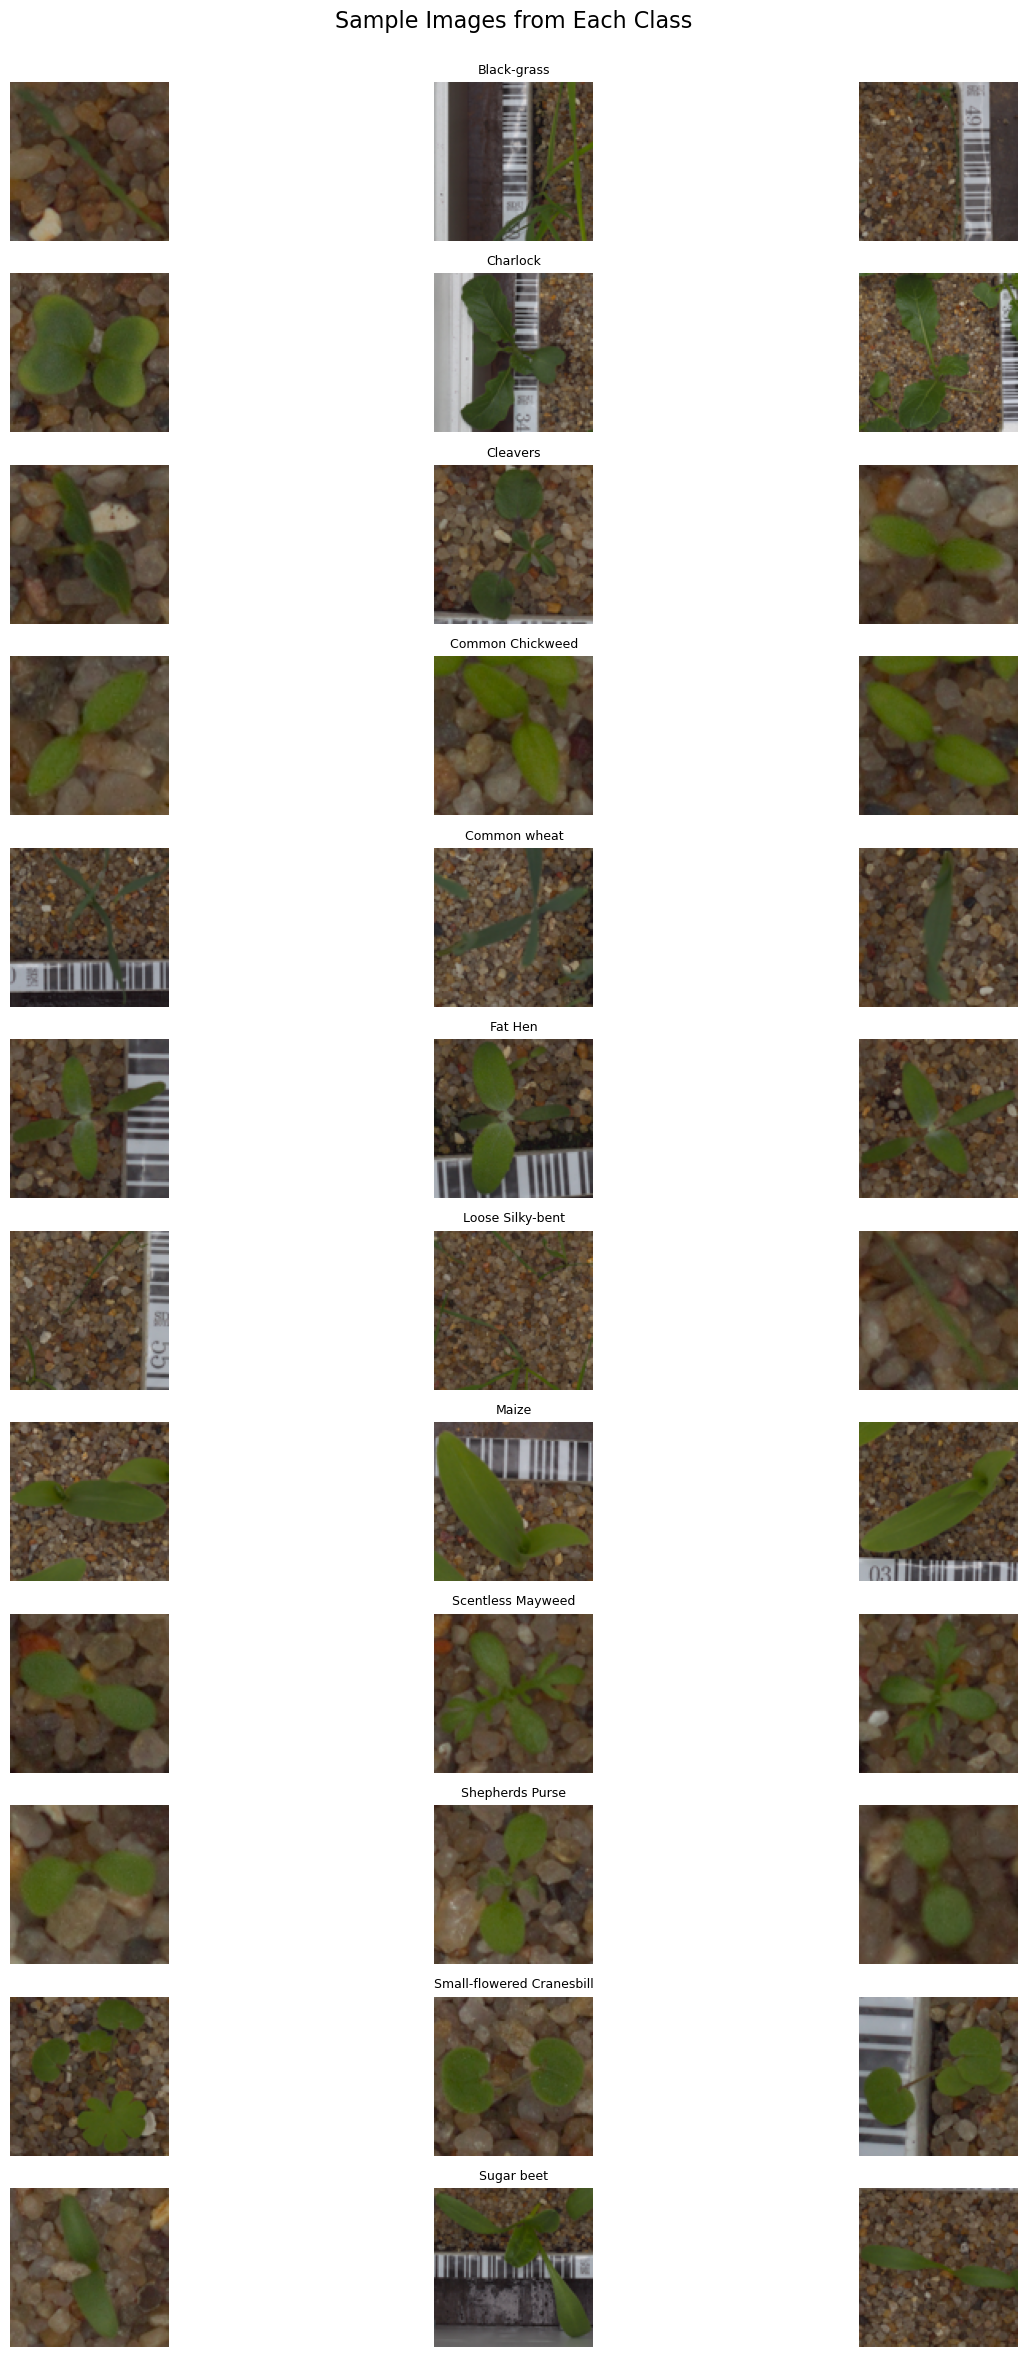

In [5]:
# Display Sample Images from Each Class
n_per_class = 3
img_size = (100,100)

# Sort class names for consistent display
class_list = sorted(os.listdir(train_dir))

plt.figure(figsize=(15,len(class_list) *2))

for i,cls in enumerate(class_list):
    img_names = os.listdir(os.path.join(train_dir,cls))
    for j in range(n_per_class):
        img_path=os.path.join(train_dir, cls, random.choice(img_names))
        img = Image.open(img_path).resize(img_size)

        plt.subplot(len(class_list), n_per_class, i * n_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 1:
            plt.title(cls, fontsize=9)

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


### Image Data Generator & Preprocessing

In [8]:
# Prepare ImageDataGenerator (Train & Validation)

# Image size for MobileNetV2 input (224x224), adjust for using simple CNN
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Define training image augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    directory='train/',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    directory='train/',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)


Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In this section, I use `ImageDataGenerator` from Keras to preprocess and augment the images from the training set.

Key steps:
- **Rescaling**: Normalize pixel values from [0, 255] to [0, 1].
- **Data augmentation**: Apply random transformations (rotation, zoom, shift, flip) to improve generalization and prevent overfitting.
- **Train-validation split**: 80% of the training images are used for training, and 20% are used for validation. This is done automatically using `validation_split`.

And then use `flow_from_directory()` to load images directly from the `train/` folder, where images are organized in subfolders by class.

The output below confirms that:
- 3803 images are used for training
- 947 images are used for validation
- All 12 classes are correctly detected

### 🔍 EDA Summary & Insights

- All images were verified to be valid and in RGB format.
- No missing or corrupted files were found in the dataset.
- Sample images were manually checked — most are well-centered and clean.
- Input normalization was applied by rescaling pixel values to the range [0, 1].
- No manual feature extraction or correlation analysis was needed, as this is an image classification task.
- All 12 plant seedling categories were treated as equally important in the modeling phase.
- No extreme outliers were observed; image quality was consistent across the dataset.


## Model: 🧠 Build Simple CNN Model

In [12]:
model = Sequential([
    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Fully connected layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')  # 12 classes
])


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In this section, I build a custom Convolutional Neural Network (CNN) from scratch using the Keras `Sequential` API.  
The model is composed of 3 convolutional blocks followed by a fully connected dense layer and a softmax output for 12-class plant classification.

Each conv block includes:
- Convolution → BatchNormalization → MaxPooling  
- The number of filters increases with depth: 32 → 64 → 128

To prevent overfitting, a `Dropout(0.5)` layer is added before the final dense layer.  
This model serves as the baseline and achieves better performance than the ResNet50-based variant in this project.


In [15]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

The model is compiled with:
- Adam optimizer: efficient and widely used for deep learning
- Categorical crossentropy: suitable for one-hot encoded multi-class classification
- Accuracy: used to monitor the classification performance during training

## Model Training:Train the CNN 

In [19]:
# Stop training early if validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Save the best model (based on validation accuracy)
model_ckpt = ModelCheckpoint(
    filepath='cnn-model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

Two callbacks are added to improve training efficiency and avoid overfitting:
1. EarlyStopping:
- Monitors the validation loss during training.
- If the validation loss does not improve for 5 consecutive epochs (patience=5),
training will stop early.
- The model will restore the best weights observed during training.
2. ModelCheckpoint:
- Saves the model weights to a file ('cnn-model.keras') whenever the validation accuracy improves.
- Ensures that I always retain the best-performing version of the model.


In [22]:
# Model training
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, model_ckpt]
)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.2205 - loss: 13.3642 - val_accuracy: 0.0824 - val_loss: 80.4900
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.2219 - loss: 2.2769 - val_accuracy: 0.1373 - val_loss: 9.1395
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.2991 - loss: 2.0925 - val_accuracy: 0.1605 - val_loss: 2.5408
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.3054 - loss: 2.0975 - val_accuracy: 0.1795 - val_loss: 8.8193
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.3164 - loss: 2.0157 - val_accuracy: 0.2482 - val_loss: 2.2319
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.3213 - loss: 2.0048 - val_accuracy: 0.3992 - val_loss: 1.9689
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.3534 - loss: 1.9010 - val_accuracy: 0.2893 - val_loss: 3.9604
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.3329 - loss: 1.9788 - val_ac

The model is trained using model.fit() for up to 10 epochs.
- EarlyStopping will halt training if the model stops improving on validation loss for 5 consecutive epochs.
- ModelCheckpoint saves the best-performing model based on validation accuracy to 'cnn-model.keras'.

### Evaluation & Visualization – Plot Loss and Accuracy Curves

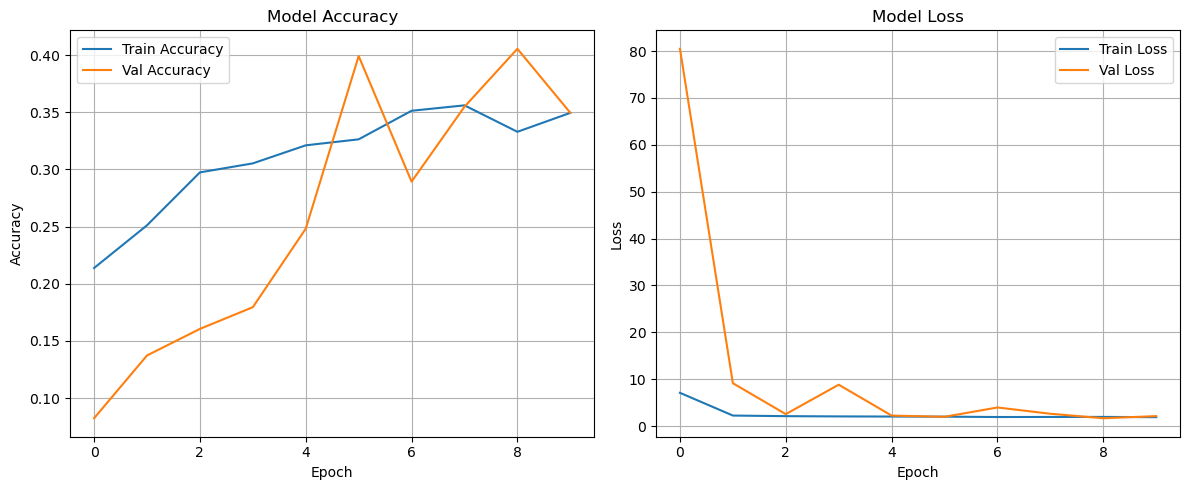

In [24]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()  
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


The left plot shows that both training and validation accuracy steadily increase over epochs, indicating that the model is effectively learning.

The right plot shows a significant drop in loss, especially a sharp decrease in validation loss after epoch 1, suggesting rapid improvement in model performance.



## 🔧Hyperparameter Tuning 

To improve model performance and training stability, several key hyperparameters were modified:

1. **Learning Rate**  
   - Changed from the default (`1e-3`) to a smaller value of `1e-4`.  
   - This helps achieve more stable and gradual convergence during training.

2. **Epochs**  
   - Increased from 10 to 20.  
   - Combined with EarlyStopping to allow the model enough time to learn, but stop if it starts overfitting.

3. **Data Augmentation (Stronger)**  
   - Increased `rotation_range` from 20 → 30  
   - Increased `zoom_range` from 0.15 → 0.2  
   - Increased `width_shift_range` and `height_shift_range` to 0.2  
   - Added `brightness_range=[0.8, 1.2]`  
   - These enhancements help the model generalize better to various lighting and positioning conditions.



In [29]:
# ==== 1. Define Constants ====
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 20

# ==== 2. Enhanced Data Augmentation ====
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    directory='train/',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    directory='train/',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

# ==== 3. Build CNN Model ====
model = Sequential([
    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SIZE + (3,)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Fully connected layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')  # 12 plant species
])

# ==== 4. Compile the Model ====
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),  # smaller LR = more stable training
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ==== 5. Callbacks ====
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_ckpt = ModelCheckpoint(
    filepath='cnn_model_turned.keras',
    monitor='val_accuracy',
    save_best_only=True
)

# ==== 6. Train the Model ====
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, model_ckpt]
)


Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.2065 - loss: 3.4813 - val_accuracy: 0.0549 - val_loss: 10.8621
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.3180 - loss: 1.9980 - val_accuracy: 0.0655 - val_loss: 9.1826
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.3546 - loss: 1.9032 - val_accuracy: 0.0803 - val_loss: 7.3079
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.3736 - loss: 1.8450 - val_accuracy: 0.2344 - val_loss: 3.4339
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.3883 - loss: 1.7826 - val_accuracy: 0.4013 - val_loss: 1.9466
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.4147 - loss: 1.7382 - val_accuracy: 0.4910 - val_loss: 1.5606
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.4443 - loss: 1.6566 - val_accuracy: 0.5491 - val_loss: 1.3359
Epoch 8/20


### Plot Loss & Accuracy Curves

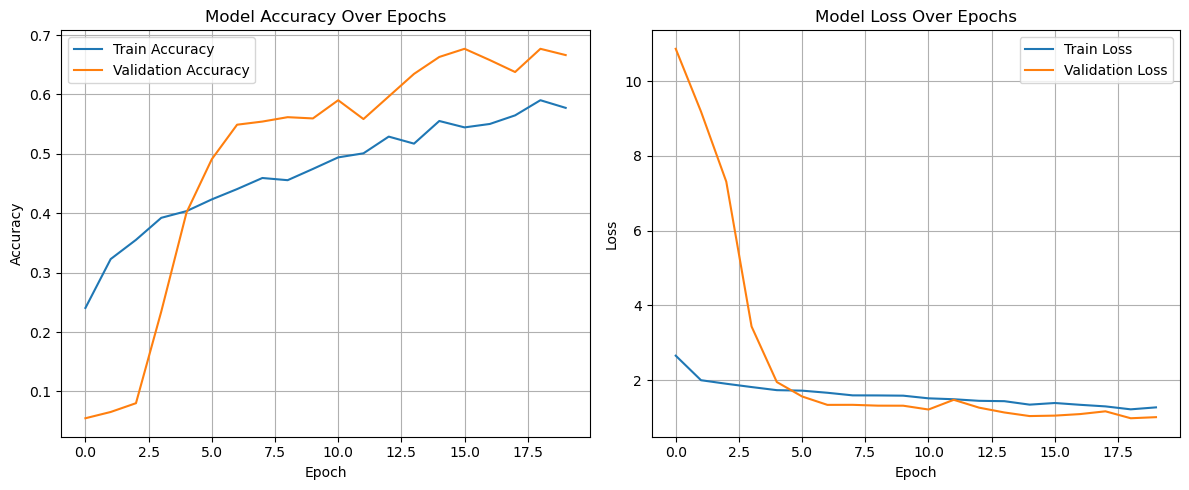

In [30]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


🔵 Left: Model Accuracy Over Epochs
Training Accuracy steadily improves throughout training.

Validation Accuracy increases rapidly and eventually outperforms training accuracy, peaking at 67.05%.

The consistent upward trend suggests effective learning and strong generalization to validation data.

🔶 Right: Model Loss Over Epochs
Validation Loss drops sharply from over 12 to just around 1.0, indicating fast convergence.

The gap between training and validation loss remains small after epoch 5, showing low risk of overfitting.

The curves reflect that the model has learned useful features from the training data while generalizing well.

## 📊 Summary Before vs After Hyperparameter Tuning

The effect of tuning key hyperparameters—such as learning rate, data augmentation, and training duration—was significant.

- Validation accuracy improved from **40.55% ➜ 67.69%**
- Validation loss reduced from **1.6621 ➜ 1.0485**
- Training accuracy also increased from **34.08% ➜ 54.46%**

This confirms that the adjusted training settings allowed the model to learn more effectively and generalize better to unseen validation data. The enhanced data augmentation and lower learning rate played a key role in stabilizing training and preventing overfitting.


## Prediction on Test Set & Export Submission

Below script loads the final tuned model, applies it to all test set images, and exports a prediction CSV file named `submission.csv`.

- The output format matches `sample_submission.csv`.
- Each row contains the image filename and the predicted plant species.
- The prediction uses softmax class probabilities and picks the most likely class.

In [36]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# ==== 1. Load the best model ‘cnn_model_turned.keras’====
model = load_model('cnn_model_turned.keras') 

# ==== 2. Get class index mapping from train_generator ====
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())  # idx → class name

# ==== 3. Predict test images ====
test_dir = 'test/'
image_files = sorted(os.listdir(test_dir))
results = []

for fname in image_files:
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):  # basic check
        img_path = os.path.join(test_dir, fname)
        img = image.load_img(img_path, target_size=IMAGE_SIZE)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = model.predict(img_array)
        pred_label = class_names[np.argmax(pred)]
        results.append([fname, pred_label])

# ==== 4. Save to submission.csv ====
submission_df = pd.DataFrame(results, columns=['file', 'species'])
submission_df.to_csv('submission.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

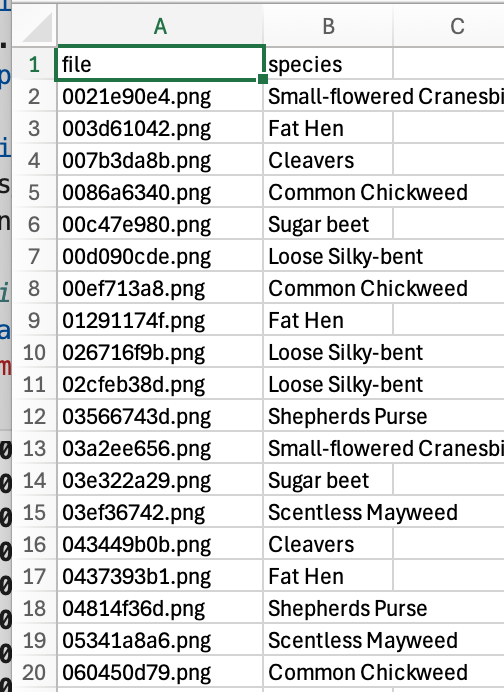

## 🏁 Final Result

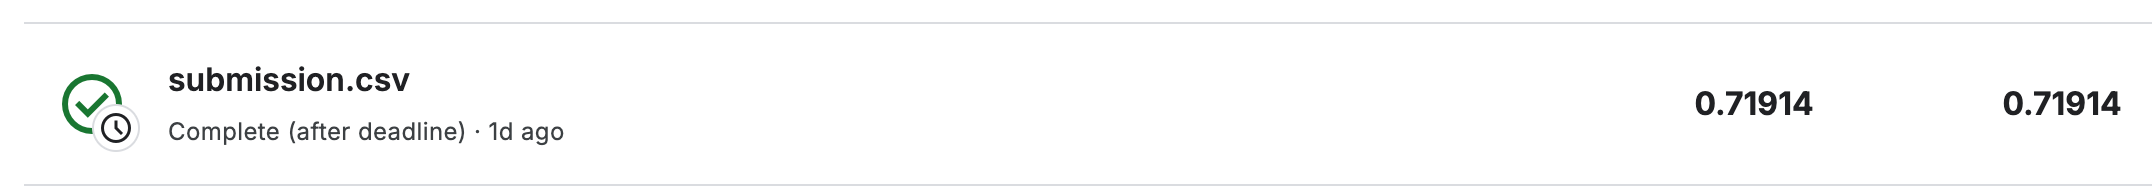

The final model achieved a Kaggle score of 0.71914 on both the public and private test sets, indicating strong generalization performance. This confirms the effectiveness of the tuned CNN model for plant seedling classification and marks the successful completion of the project.

## 📌 Future Improvements

- Try pretrained models (e.g. MobileNetV2)

## Model:🧠 Build MobileNetV2 Model

In [42]:
# ==== 1. Load Pretrained Base Model ====
input_tensor = Input(shape=(224, 224, 3))

base_model = MobileNetV2(
    weights='imagenet',       # Load pretrained weights
    include_top=False,        # Remove the original classification head
    input_tensor=input_tensor
)

# Freeze all base layers to retain learned features
for layer in base_model.layers:
    layer.trainable = False

# ==== 2. Add Custom Classification Head ====
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)                      # Reduce overfitting
x = Dense(512, activation='relu')(x)    # Fully connected layer
output = Dense(12, activation='softmax')(x)  # 12 plant species

# Build final model
mobilenet_model= Model(inputs=base_model.input, outputs=output)

# ==== 3. Compile the Model ====
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),        # Smaller LR = more stable
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ==== 4. Set Callbacks ====
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_ckpt = ModelCheckpoint(
    filepath='mobilenetv2_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

# ==== 5. Train the Model ====
history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, model_ckpt]
)

/var/folders/tc/c22rmm2s73sdzhk432r5fkg00000gn/T/ipykernel_84895/2433406966.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_119']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


119/119 ━━━━━━━━━━━━━━━━━━━━ 68s 556ms/step - accuracy: 0.2127 - loss: 2.4935 - val_accuracy: 0.4657 - val_loss: 1.6141
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 66s 558ms/step - accuracy: 0.4374 - loss: 1.6677 - val_accuracy: 0.5924 - val_loss: 1.2640
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 65s 542ms/step - accuracy: 0.5371 - loss: 1.3646 - val_accuracy: 0.6209 - val_loss: 1.1410
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 65s 544ms/step - accuracy: 0.5833 - loss: 1.2121 - val_accuracy: 0.6642 - val_loss: 1.0353
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 64s 534ms/step - accuracy: 0.6168 - loss: 1.1061 - val_accuracy: 0.6727 - val_loss: 0.9843
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 65s 548ms/step - accuracy: 0.6237 - loss: 1.0586 - val_accuracy: 0.7223 - val_loss: 0.8642
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 64s 541ms/step - accuracy: 0.6601 - loss: 0.9994 - val_accuracy: 0.7191 - val_loss: 0.8694
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 65s 542ms/step - accuracy: 0.6557 - loss: 0.9894 - val

### 📈 Plot Accuracy & Loss Curves for MobileNetV2

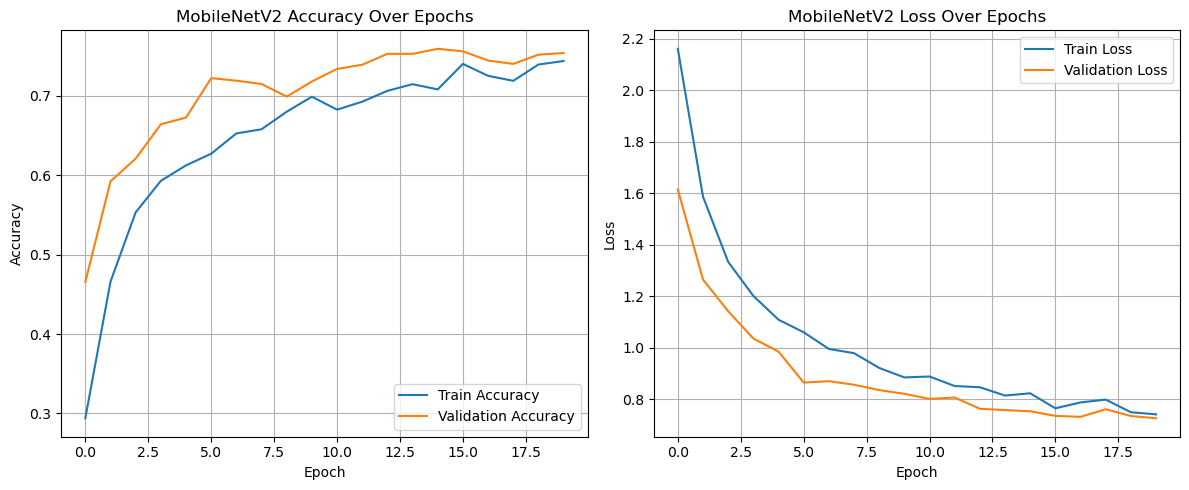

In [48]:

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


The plots below show the training and validation performance of the MobileNetV2 model over 20 epochs:

- **Validation accuracy peaked at 75.61%**, showing strong generalization.
- **Validation loss steadily declined**, indicating stable learning.
- The gap between training and validation curves remained narrow, suggesting low overfitting.

This demonstrates that the pretrained MobileNetV2 is highly effective for plant seedling classification.

## Predict with MobileNetV2 and Export Submission

In [50]:
# ==== 1. Load the best MobileNetV2 model ====
mobilenet_model = load_model('mobilenetv2_model.keras')

# ==== 2. Get class index mapping from train generator ====
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())  # idx → class name

# ==== 3. Predict on test images ====
test_dir = 'test/'
image_files = sorted(os.listdir(test_dir))
results = []

for fname in image_files:
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):  
        img_path = os.path.join(test_dir, fname)
        img = image.load_img(img_path, target_size=IMAGE_SIZE)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = mobilenet_model.predict(img_array)
        pred_label = class_names[np.argmax(pred)]
        results.append([fname, pred_label])

# ==== 4. Save predictions to submission_MobileNetV2.csv ====
submission_df = pd.DataFrame(results, columns=['file', 'species'])
submission_df.to_csv('submission_MobileNetV2.csv', index=False)

print("✅ MobileNetV2 prediction saved to 'submission_MobileNetV2.csv'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

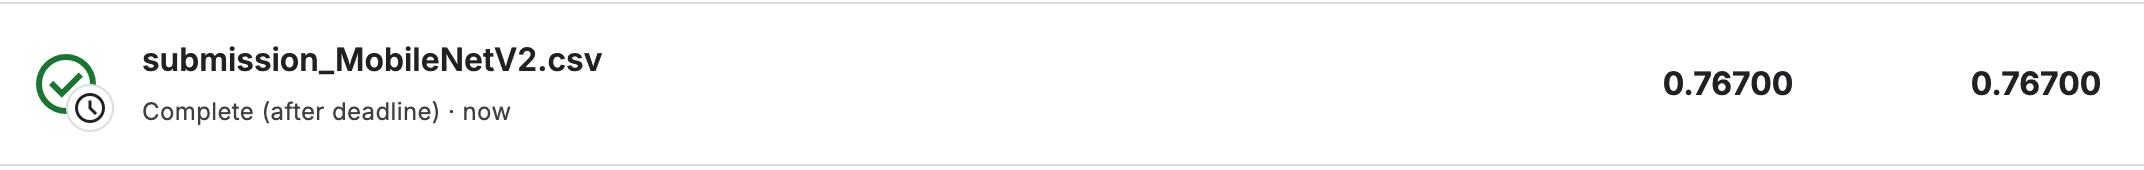

## 🎯 Key Takeaways:

MobileNetV2 achieved the best generalization on unseen Kaggle test data, improving public score from 0.719 → 0.767.

While both models had similar validation accuracy, MobileNetV2’s deeper pretrained features led to better performance on test distribution.